In [1]:
!pip install -U sentence-transformers
!pip install --upgrade scikit-learn
print("Installation complete. Sentence-Transformers is ready.")

from pathlib import Path

KAGGLE_INPUT = Path("/kaggle/input/da5401-2025-data-challenge")
LOCAL_INPUT  = Path("/mnt/data")
DATA_DIR = KAGGLE_INPUT if KAGGLE_INPUT.exists() else LOCAL_INPUT

OUT_DIR = Path("/kaggle/working") if Path("/kaggle").exists() else Path(".")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("OUT_DIR :", OUT_DIR)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 8.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset
train_df = pd.DataFrame(json.load(open(DATA_DIR / 'train_data.json', 'r')))
test_df = pd.DataFrame(json.load(open(DATA_DIR / 'test_data.json', 'r')))
metric_embeddings = np.load(DATA_DIR / 'metric_name_embeddings.npy')
with open(DATA_DIR / 'metric_names.json', 'r') as f:
    metric_names = json.load(f)


train_df['score'] = pd.to_numeric(train_df['score'], errors='coerce')


for col in ['response', 'system_prompt']:
    train_df[col] = train_df[col].fillna("")
    test_df[col] = test_df[col].fillna("")


test_df['ID'] = test_df.index + 1

print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("Metric Embedding Shape:", metric_embeddings.shape)
print("\nTrain Data Missing Text Check (Count of empty strings):")
print(train_df[['response', 'system_prompt']].apply(lambda x: (x == "").sum()))

2025-11-20 12:22:56.493490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763641376.675372      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763641376.725016      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train Data Shape: (5000, 5)
Test Data Shape: (3638, 5)
Metric Embedding Shape: (145, 768)

Train Data Missing Text Check (Count of empty strings):
response            1
system_prompt    1549
dtype: int64


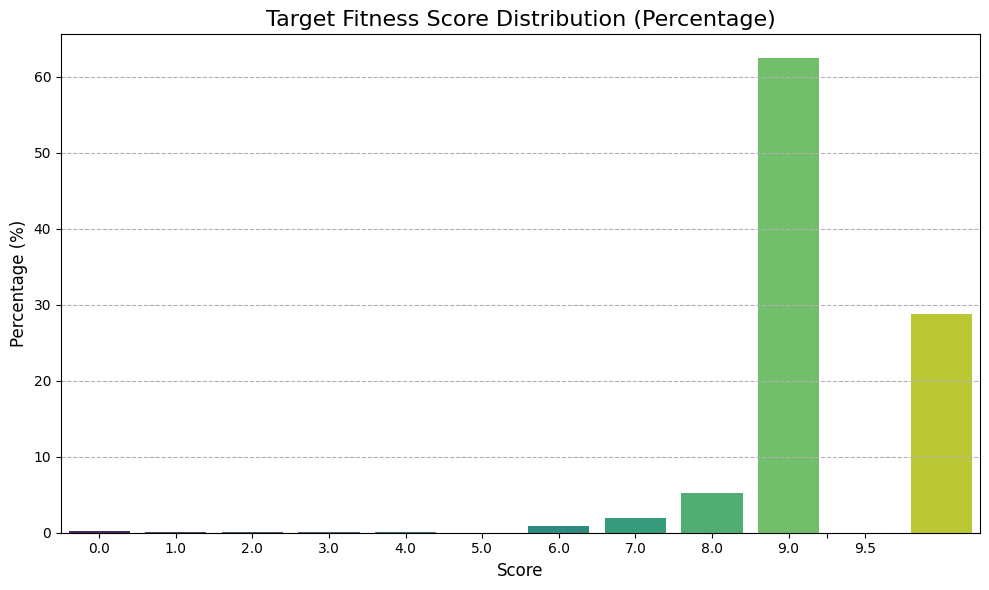

Target Score Summary Statistics:
count    5000.000000
mean        9.119500
std         0.942416
min         0.000000
25%         9.000000
50%         9.000000
75%        10.000000
max        10.000000
Name: score, dtype: float64

Scores 9.0 and 10.0 account for 91.30% of the data.


In [3]:
score_counts = train_df['score'].value_counts(normalize=True).sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=score_counts.index, y=score_counts.values * 100, palette='viridis')
plt.title('Target Fitness Score Distribution (Percentage)', fontsize=16)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(score_counts.index)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

plt.savefig(OUT_DIR / 'score_distribution_barplot.png')
plt.close()

print("Target Score Summary Statistics:")
print(train_df['score'].describe())
print(f"\nScores 9.0 and 10.0 account for {score_counts.loc[[9.0, 10.0]].sum()*100:.2f}% of the data.")

In [4]:
metric_to_idx = {name: i for i, name in enumerate(metric_names)}

def get_metric_index(metric_name):
    return metric_to_idx.get(metric_name, -1) 

train_df['metric_idx'] = train_df['metric_name'].apply(get_metric_index)
test_df['metric_idx'] = test_df['metric_name'].apply(get_metric_index)

X_train_metric = metric_embeddings[train_df['metric_idx'].values]
X_test_metric = metric_embeddings[test_df['metric_idx'].values]

print("X_train_metric Shape (Metric Embeddings for Training):", X_train_metric.shape)
print("X_test_metric Shape (Metric Embeddings for Testing):", X_test_metric.shape)


X_train_metric Shape (Metric Embeddings for Training): (5000, 768)
X_test_metric Shape (Metric Embeddings for Testing): (3638, 768)


In [5]:
def combine_text_features(row):
    prompt_text = f"[P] {row['user_prompt']}"
    response_text = f"[R] {row['response']}"

    system_text = f"[S] {row['system_prompt']}" if row['system_prompt'] else ""
    
    return f"{prompt_text} {response_text} {system_text}"

train_df['combined_text'] = train_df.apply(combine_text_features, axis=1)
test_df['combined_text'] = test_df.apply(combine_text_features, axis=1)

print("Successfully created 'combined_text' column.")
print("Combined Text Sample (Train Row 0):")
print(train_df['combined_text'].iloc[0][:150] + "...") 

Successfully created 'combined_text' column.
Combined Text Sample (Train Row 0):
[P] எனக்கு கொஞ்ச நாளா வயித்துல வலிக்குது. என் பிரெண்ட்ஸ் கிட்ட கேட்ட கிட்னி பிராப்ளம்னு சொல்றாங்க. என்னால டாக்டரு கிட்ட போக பயமா இருக்கு. அதனால எனக...


In [6]:

from sentence_transformers import SentenceTransformer
import torch

MODEL_NAME = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    print(f"Loading SentenceTransformer model: {MODEL_NAME} on {DEVICE}...")
    text_encoder = SentenceTransformer(MODEL_NAME, device=DEVICE)
except Exception as e:
    print(f"Error loading model: {e}")
    raise e


print("Starting encoding of training data...")
X_train_text = text_encoder.encode(
    train_df['combined_text'].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=False
)
np.save(OUT_DIR / 'X_train_text.npy', X_train_text)
print(f"X_train_text encoded and saved. Shape: {X_train_text.shape}")


print("Starting encoding of test data...")
X_test_text = text_encoder.encode(
    test_df['combined_text'].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=False
)
np.save(OUT_DIR / 'X_test_text.npy', X_test_text)
print(f"X_test_text encoded and saved. Shape: {X_test_text.shape}")


X_train_metric = metric_embeddings[train_df['metric_idx'].values]
X_test_metric = metric_embeddings[test_df['metric_idx'].values]

X_train = np.concatenate([X_train_metric, X_train_text], axis=1)
X_test = np.concatenate([X_test_metric, X_test_text], axis=1)
Y_train = train_df['score'].values

print(f"Final combined training feature shape: {X_train.shape}")

Loading SentenceTransformer model: sentence-transformers/paraphrase-multilingual-mpnet-base-v2 on cuda...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Starting encoding of training data...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

X_train_text encoded and saved. Shape: (5000, 768)
Starting encoding of test data...


Batches:   0%|          | 0/114 [00:00<?, ?it/s]

X_test_text encoded and saved. Shape: (3638, 768)
Final combined training feature shape: (5000, 1536)


In [7]:
positive_indices = np.where(Y_train >= 9.0)[0]

AUGMENTATION_RATIO = 0.5
num_samples_to_augment = int(len(positive_indices) * AUGMENTATION_RATIO)


indices_for_augmentation = np.random.choice(
    positive_indices, 
    size=num_samples_to_augment, 
    replace=False
)
print(f"Targeted Augmentation: Generating {num_samples_to_augment} hard negative samples (50% of positives).")

X_aug_metric = []
X_aug_text = []
Y_aug = []

all_metric_indices = np.arange(len(metric_names))

for i in indices_for_augmentation:
    original_metric_idx = train_df['metric_idx'].iloc[i]
    
    opponent_metric_idx = np.random.choice(all_metric_indices[all_metric_indices != original_metric_idx])

    new_metric_embedding = metric_embeddings[opponent_metric_idx]
    
    original_text_embedding = X_train_text[i]
    
    new_score = 1.0 
    
    X_aug_metric.append(new_metric_embedding)
    X_aug_text.append(original_text_embedding)
    Y_aug.append(new_score)

X_train_metric = np.concatenate([X_train_metric, np.array(X_aug_metric)], axis=0)
X_train_text = np.concatenate([X_train_text, np.array(X_aug_text)], axis=0)
Y_train = np.concatenate([Y_train, np.array(Y_aug)], axis=0)

print(f"Total training samples after augmentation: {X_train_metric.shape[0]}")

Targeted Augmentation: Generating 2283 hard negative samples (50% of positives).
Total training samples after augmentation: 7283


In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

X_train_metric_t = torch.tensor(X_train_metric, dtype=torch.float32)
X_train_text_t = torch.tensor(X_train_text, dtype=torch.float32)
X_test_metric_t = torch.tensor(X_test_metric, dtype=torch.float32)
X_test_text_t = torch.tensor(X_test_text, dtype=torch.float32)

X_train_diff = (X_train_metric_t - X_train_text_t).numpy()
X_train_prod = (X_train_metric_t * X_train_text_t).numpy()
X_test_diff = (X_test_metric_t - X_test_text_t).numpy()
X_test_prod = (X_test_metric_t * X_test_text_t).numpy()

X_train_final = np.concatenate([X_train_metric, X_train_text, X_train_diff, X_train_prod], axis=1)
X_test_final = np.concatenate([X_test_metric, X_test_text, X_test_diff, X_test_prod], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

print(f"Final Scaled X_train_final shape: {X_train_scaled.shape}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(DEVICE)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1).to(DEVICE)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(DEVICE)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(" Data preparation complete. 'X_train_tensor' is defined.")

Final Scaled X_train_final shape: (7283, 3072)
 Data preparation complete. 'X_train_tensor' is defined.


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd


N_FOLDS = 5
EPOCHS = 40         
BATCH_SIZE = 64
LEARNING_RATE = 2e-4  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AggressiveTwoTowerLearner(nn.Module):
    def __init__(self, embedding_size=768):
        super(AggressiveTwoTowerLearner, self).__init__()
        
        self.embedding_size = embedding_size
        
        self.tower_A = nn.Sequential(
            nn.Linear(embedding_size, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.15)                 
        )
        
        self.tower_B = nn.Sequential(
            nn.Linear(embedding_size, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.15)                 
        )
        

        self.final_layers = nn.Sequential(
            nn.Linear(1024 + 1024 + 2 * embedding_size, 2048), 
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        metric_emb = x[:, 0 * self.embedding_size : 1 * self.embedding_size]
        text_emb   = x[:, 1 * self.embedding_size : 2 * self.embedding_size]
        diff_emb   = x[:, 2 * self.embedding_size : 3 * self.embedding_size]
        prod_emb   = x[:, 3 * self.embedding_size : 4 * self.embedding_size]
        
        z_A = self.tower_A(metric_emb)
        z_B = self.tower_B(text_emb)
        
        combined_features = torch.cat((z_A, z_B, diff_emb, prod_emb), dim=1)
        
        return self.final_layers(combined_features)


X = X_train_scaled
y = Y_train

oof_preds = np.zeros(X.shape[0])
test_preds = np.zeros(X_test_scaled.shape[0])

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

print(f"Starting Aggressive {N_FOLDS}-Fold Training...")

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"\n--- Fold {fold + 1} / {N_FOLDS} ---")
    
    X_train_fold = torch.tensor(X[train_idx], dtype=torch.float32).to(DEVICE)
    y_train_fold = torch.tensor(y[train_idx], dtype=torch.float32).view(-1, 1).to(DEVICE)
    
    X_val_fold = torch.tensor(X[val_idx], dtype=torch.float32).to(DEVICE)
    y_val_fold = torch.tensor(y[val_idx], dtype=torch.float32).view(-1, 1).to(DEVICE)
    
    train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=BATCH_SIZE, shuffle=False)
    

    model = AggressiveTwoTowerLearner(embedding_size=768).to(DEVICE)
    
    criterion = nn.HuberLoss(delta=1.0) 
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        scheduler.step(epoch + val_loss/len(val_loader))
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss {avg_train_loss:.4f} | Val Loss {avg_val_loss:.4f}")

    model.load_state_dict(best_model_state)
    
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(DEVICE)
    model.eval()
    with torch.no_grad():
        fold_test_preds = model(X_test_tensor).cpu().numpy().flatten()
        test_preds += fold_test_preds / N_FOLDS

final_scores = np.clip(np.round(test_preds), 0, 10)

submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'score': final_scores.astype(float)
})

print("\nTraining Complete.")
print("Score Distribution:")
print(submission_df['score'].value_counts().sort_index())

submission_file_path = OUT_DIR / 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)
print(f"Tuned submission saved to {submission_file_path}")

Starting Aggressive 5-Fold Training...

--- Fold 1 / 5 ---
Epoch 0: Train Loss 2.8389 | Val Loss 2.3358
Epoch 10: Train Loss 1.4198 | Val Loss 2.0044
Epoch 20: Train Loss 0.5703 | Val Loss 1.8898
Epoch 30: Train Loss 0.6629 | Val Loss 1.8859

--- Fold 2 / 5 ---
Epoch 0: Train Loss 2.7817 | Val Loss 2.3582
Epoch 10: Train Loss 1.3296 | Val Loss 1.9812
Epoch 20: Train Loss 0.5839 | Val Loss 1.8229
Epoch 30: Train Loss 0.5955 | Val Loss 1.9349

--- Fold 3 / 5 ---
Epoch 0: Train Loss 2.7345 | Val Loss 2.5491
Epoch 10: Train Loss 1.2835 | Val Loss 2.0929
Epoch 20: Train Loss 0.5325 | Val Loss 1.9095
Epoch 30: Train Loss 0.5955 | Val Loss 1.9190

--- Fold 4 / 5 ---
Epoch 0: Train Loss 2.7712 | Val Loss 2.5002
Epoch 10: Train Loss 1.3744 | Val Loss 2.0062
Epoch 20: Train Loss 0.6488 | Val Loss 1.8367
Epoch 30: Train Loss 0.6702 | Val Loss 1.9247

--- Fold 5 / 5 ---
Epoch 0: Train Loss 2.7110 | Val Loss 2.5989
Epoch 10: Train Loss 1.3534 | Val Loss 2.2169
Epoch 20: Train Loss 0.6007 | Val Loss